In [2]:
!pip install langgraph langchain-google-genai pydantic langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.3 MB/s eta 0:00:00


In [3]:
from langgraph.graph import StateGraph , START  , END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict , Annotated , Literal
from pydantic import BaseModel , Field
import operator
from langchain_core.messages import SystemMessage, HumanMessage

In [4]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

In [28]:
generator_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
    , api_key= api_key)

In [29]:
evaluator_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash" # get a good llm for elvaluation
    , api_key= api_key)

In [30]:
optimizer_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash" # get a good llm for elvaluation
    , api_key= api_key)

In [31]:
class TweetState(TypedDict):
  topic : str
  tweet : str
  evaluation : Literal["approved" , "needs_improvement"]
  feedback:  str
  iteration : int
  max_iteration : int #to avoid infinite loops
  tweet_history: Annotated[list[str], operator.add]
  feedback_history: Annotated[list[str], operator.add]

In [47]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 100 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_model.invoke(messages).content

    # return response
    return {'tweet': response , 'tweet_history': [response]}

In [48]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [49]:
structured_evaluator_llm = evaluator_model.with_structured_output(TweetEvaluation)

In [50]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?
2. Humor – Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness – Is it short, sharp, and scroll-stopping?
4. Virality Potential – Would people retweet or share it?
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 100 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
- feedback: One paragraph explaining the strengths and weaknesses
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [51]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_model.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration ,  'tweet_history': [response]}

In [52]:
def route_evaluation(state:  TweetState):
  if state['evaluation']== 'approved' or state['iteration']>= state['max_iteration']:
    return 'approved'
  else :
    return 'needs_improvement'

In [53]:
graph = StateGraph(TweetState)

graph.add_node('generate' , generate_tweet)
graph.add_node('evaluate' , evaluate_tweet)
graph.add_node('optimize' , optimize_tweet)

graph.add_edge(START , 'generate')
graph.add_edge('generate' , 'evaluate')

graph.add_conditional_edges('evaluate' , route_evaluation , {'approved' : END ,  'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

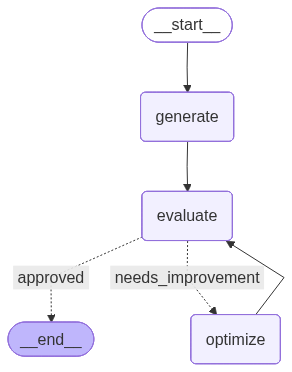

In [54]:
graph.compile()

In [64]:

initial_state = {
    "topic": "DT.HGGFSSXFV",
    "iteration": 1,
    "max_iteration": 3
}
result = workflow.invoke(initial_state)

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 31.77301754s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '31s'}]}}

In [65]:
result


{'topic': 'YUYUUUtok',
 'tweet': "My productivity died on YUYUUUtok. Its last words were 'YUYUUU'. RIP my to-do list.",
 'evaluation': 'approved',
 'feedback': "This tweet is effective due to its relatable humor and concise delivery. The personification of productivity dying on 'YUYUUUtok' with its last words being 'YUYUUU' is a fresh, quirky take on a common sentiment, making it genuinely chuckle-worthy. It is short, sharp, and highly scroll-stopping, fitting perfectly within the tweet format without exceeding character limits or resorting to a traditional setup-punchline structure. Its strong punchiness and broad relatability to anyone who has lost hours to short-form video platforms give it significant virality potential. The ending, 'RIP my to-do list,' is a strong, fitting conclusion that enhances the humor rather than deflating it.",
 'iteration': 1,
 'max_iteration': 3,
 'tweet_history': ["My productivity died on YUYUUUtok. Its last words were 'YUYUUU'. RIP my to-do list."],
 'f